# Exercise 9 - Solution 

* You can find a reference implementation of the Ghil-Sellers EBM as a package on [GitHub](https://github.com/maximilian-gelbrecht/GhilSellersEBM.jl), this packge will also be used in this solution

## Basin Boundary 

From the last animation from the lecture, we've seen that the basin boundary must be somewhere between $260 K$ and $280 K$. The basin boundary of the model is a saddle point, trajectories that start very close to it will remain there for quite a long time until converging to one of the stable fixed points. This model only has those two fixed points within the interval of initial conditions that is interesting to us, we will therefore assume that every trajectory those average temperature at a later point in time is smaller than the intial condtion will eventually reach the cold stable fixed. 

In [1]:
import Pkg
Pkg.activate(".")
using GhilSellersEBM, DifferentialEquations, StatsBase 

x = (-90.:5.:90.)./90.
grid = Grid(x)
p = ContinousGhilSellersParameters(grid, order="2nd");

function final_temperature(T_0, p, tspan=(0.,1e9))
        prob = ODEProblem(ghilsellers_ebm!, T_0 .* ones(Float64, p.g.N), tspan, p)
        sol = solve(prob)
        mean(sol(tspan[2]))
end 

  Activating project at `~/Nextcloud/TUMLecture/dyn-modelling`


final_temperature (generic function with 2 methods)

In [2]:
T_0s = 260:1:280
T_fs = [final_temperature(T,p) for T ∈ T_0s]

21-element Vector{Float64}:
 218.53522403781798
 218.53700922143267
 218.54213873022798
 218.54885919770433
 218.56123428947018
 218.57095049284706
 218.5952784670156
 218.6335001200986
 218.72524604800174
 219.00372328420048
 222.04062615763016
 275.61428833568516
 277.118259804438
 277.73497259859283
 278.0784153667842
 278.29924421965063
 278.4703558467566
 278.5726837933314
 278.6930776906655
 278.7725066735386
 278.83620309978056

So, the basin boundary is somewhere between 270 K and 272 K. Let's compute it a little closer, also increasing the `tspan`

In [3]:
function which_basin(T_0, p) 
    if final_temperature(T_0,p,(0.,1e10)) < T_0
        return "cold"
    else
        return "warm"
    end 
end

T_0s = 270:0.1:272
basins = [which_basin(T_0,p) for T_0 ∈ T_0s] 

21-element Vector{String}:
 "cold"
 "cold"
 "cold"
 "cold"
 "warm"
 "warm"
 "warm"
 "warm"
 "warm"
 "warm"
 "warm"
 "warm"
 "warm"
 "warm"
 "warm"
 "warm"
 "warm"
 "warm"
 "warm"
 "warm"
 "warm"

We could now zoom into that region even further, potentially also with some more proper algorithm to save some computations, but the model itself is also only a conceptual, coarse model, so we will leave our estimate for the basin bounday at $T_c=270.35K$

Let's look at some trajectories very close to it! They will remain for a really long time close the unstable saddle point. [Lucarini et al](https://iopscience.iop.org/article/10.1088/1361-6544/ab86cc/meta) coined the term 'Melancholia states' for these kind of states. We will massively increase the integration time:



In [4]:
tspan = (0.,1e9)
prob = ODEProblem(ghilsellers_ebm!, 270.3 .* ones(Float64, p.g.N), tspan, p)
sol_1 = solve(prob)
sol_2 = solve(remake(prob, u0=270.4 .* ones(Float64, p.g.N)));
sol_3 = solve(remake(prob, u0=270.2 .* ones(Float64, p.g.N)));

┌ Info: Saved animation to 
│   fn = /Users/max/Nextcloud/TUMLecture/dyn-modelling/ebm-anim.gif
└ @ Plots /Users/max/.julia/packages/Plots/E2187/src/animation.jl:126


Plots.AnimatedGif("/Users/max/Nextcloud/TUMLecture/dyn-modelling/ebm-anim.gif")
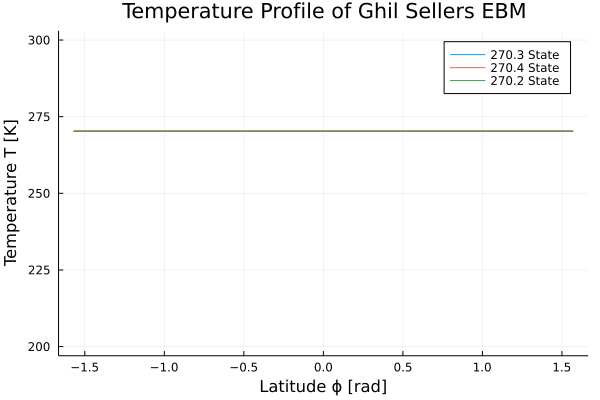

In [5]:
using Plots
t_plot = range(tspan[1],tspan[2],length=200)
anim = @animate for it ∈ t_plot
    plot(p.ϕ, sol_1(it), xlabel="Latitude ϕ [rad]", label="270.3 State", ylims=[210,300], ylabel="Temperature T [K]", title="Temperature Profile of Ghil Sellers EBM")
    plot!(p.ϕ, sol_2(it), label="270.4 State", ylims=[200,300])
    plot!(p.ϕ, sol_3(it), label="270.2 State", ylims=[200,300])


end 
gif(anim, "ebm-anim.gif", fps=10)

We see numerical inaccuricies accumulating at this point. Let's compute them with a lower solver tolerance. As a comparision we also include some solutions that start far away from the saddle point

In [6]:
tspan=(0.,1e10)
prob = ODEProblem(ghilsellers_ebm!, 270.3 .* ones(Float64, p.g.N), tspan, p)
sol_1 = solve(prob, reltol=1e-6)
sol_2 = solve(remake(prob, u0=270.4 .* ones(Float64, p.g.N)), reltol=1e-6);
sol_3 = solve(remake(prob, u0=270.2 .* ones(Float64, p.g.N)), reltol=1e-6);
sol_4 = solve(remake(prob, u0=285 .* ones(Float64, p.g.N)), reltol=1e-4);
sol_5 = solve(remake(prob, u0=255 .* ones(Float64, p.g.N)), reltol=1e-4);

┌ Info: Saved animation to 
│   fn = /Users/max/Nextcloud/TUMLecture/dyn-modelling/ebm-anim.gif
└ @ Plots /Users/max/.julia/packages/Plots/E2187/src/animation.jl:126


Plots.AnimatedGif("/Users/max/Nextcloud/TUMLecture/dyn-modelling/ebm-anim.gif")
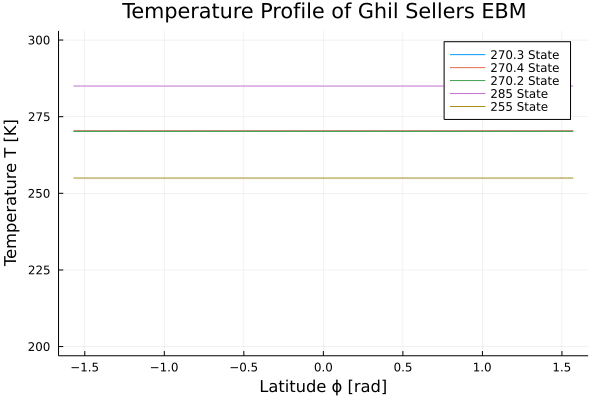

In [7]:
t_plot = range(tspan[1],tspan[2],length=200)

anim = @animate for it ∈ t_plot
  plot(p.ϕ, sol_1(it), xlabel="Latitude ϕ [rad]", label="270.3 State", ylims=[210,300], ylabel="Temperature T [K]", title="Temperature Profile of Ghil Sellers EBM")
  plot!(p.ϕ, sol_2(it), label="270.4 State", ylims=[200,300])
  plot!(p.ϕ, sol_3(it), label="270.2 State", ylims=[200,300])
  plot!(p.ϕ, sol_4(it), label="285 State", ylims=[200,300])
  plot!(p.ϕ, sol_5(it), label="255 State", ylims=[200,300])
end 
gif(anim, "ebm-anim.gif", fps=10)

We could mitigate the numerical issues further, when we would use higher order finite difference schemes, e.g. a fourth order central difference scheme. Very close to the unstable saddle points these errors start to accumulate and we are not able to compute the trajectory properly anymore. 

## Fourth Order Finite Differences 

* You can look up the coefficients on [Wikipedia](https://en.wikipedia.org/wiki/Finite_difference_coefficient)
* The GitHub repo also features this scheme [as well](https://github.com/maximilian-gelbrecht/GhilSellersEBM.jl/blob/main/src/discretization.jl)
* Let's redo the last experiment with this: 

In [8]:
p = ContinousGhilSellersParameters(grid, order="4th")
tspan=(0.,1e10)
prob = ODEProblem(ghilsellers_ebm!, 270.3 .* ones(Float64, p.g.N), tspan, p)
sol_1 = solve(prob, reltol=1e-6)
sol_2 = solve(remake(prob, u0=270.4 .* ones(Float64, p.g.N)), reltol=1e-6);
sol_3 = solve(remake(prob, u0=270.2 .* ones(Float64, p.g.N)), reltol=1e-6);
sol_4 = solve(remake(prob, u0=285 .* ones(Float64, p.g.N)), reltol=1e-4);
sol_5 = solve(remake(prob, u0=255 .* ones(Float64, p.g.N)), reltol=1e-4);

┌ Info: Saved animation to 
│   fn = /Users/max/Nextcloud/TUMLecture/dyn-modelling/ebm-anim-4th.gif
└ @ Plots /Users/max/.julia/packages/Plots/E2187/src/animation.jl:126


Plots.AnimatedGif("/Users/max/Nextcloud/TUMLecture/dyn-modelling/ebm-anim-4th.gif")
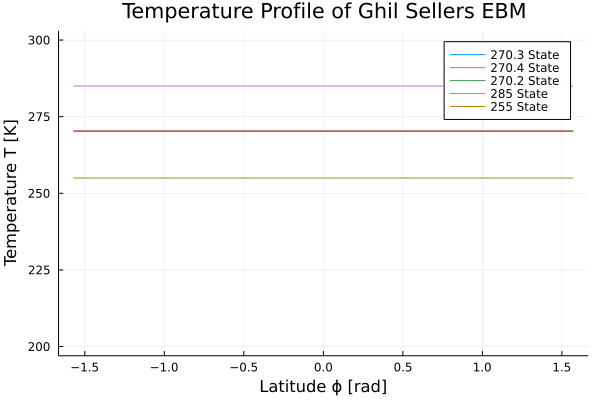

In [9]:
t_plot = range(tspan[1],tspan[2],length=200)

anim = @animate for it ∈ t_plot
  plot(p.ϕ, sol_1(it), xlabel="Latitude ϕ [rad]", label="270.3 State", ylims=[210,300], ylabel="Temperature T [K]", title="Temperature Profile of Ghil Sellers EBM")
  plot!(p.ϕ, sol_2(it), label="270.4 State", ylims=[200,300])
  plot!(p.ϕ, sol_3(it), label="270.2 State", ylims=[200,300])
  plot!(p.ϕ, sol_4(it), label="285 State", ylims=[200,300])
  plot!(p.ϕ, sol_5(it), label="255 State", ylims=[200,300])
end 
gif(anim, "ebm-anim-4th.gif", fps=10)

We see that using a more accurate finite difference scheme helps solving the equation close the basin boundary. 

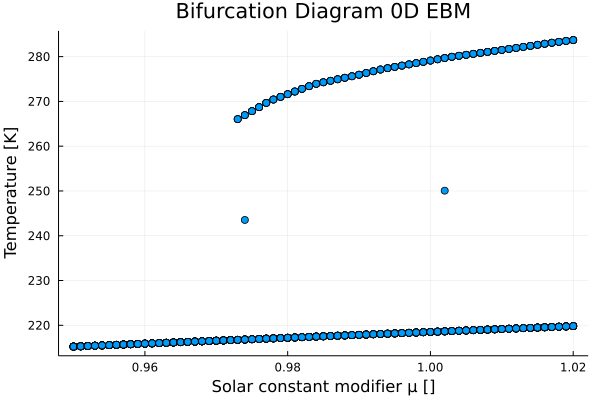

In [10]:
μs = 0.95:0.001:1.02
u0s = 210:5:290

tspan=(0.,5e10)
prob = ODEProblem(ghilsellers_ebm!, 300 .* ones(Float64, p.g.N), tspan, p)


bif_diagram = zeros(length(μs)*length(u0s),2)
count = 1
for μ ∈ μs
    p = ContinousGhilSellersParameters(grid, μ=μ)
    for u0 ∈ u0s 
        bif_diagram[count, 1] = μ
        bif_diagram[count, 2] = mean(solve(remake(prob,p=p,u0=u0*ones(Float64, p.g.N)),reltol=1e-6)(tspan[2]))
        count += 1 
    end 
end 
scatter(bif_diagram[:,1],bif_diagram[:,2],legend=nothing, xlabel="Solar constant modifier μ []", ylabel="Temperature [K]", title="Bifurcation Diagram 0D EBM")

The two isolated points that you see there are very likely states that start very close to the basin boundary and remain there much longer, we could redo the diagram with an even larger integration time to avoid this